In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import glob
from sklearn import model_selection
from Model.config import Config
import Model.utils
import Model.model as modellib
from Model import visualize
from Model.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

MODEL_PATH = os.path.join(ROOT_DIR,"Weights/mask_rcnn_irises_ND.h5" )

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
class irisConfig(Config):
    
    
    # Give the configuration a recognizable name
    NAME = "irises"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    NUM_CLASSES = 1 + 1  # background + 3 shapes

    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 50
    


class InferenceConfig(irisConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

#Loads weights from a static model file
model.load_weights(MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           irises
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS

2
Saving in /home/sohaib/Desktop/segmentation_latestrepo/Iris-segmentation-using-Mask-R-CNN-master/segmented
0.21854543685913086
0.5608489513397217
0.7793943881988525


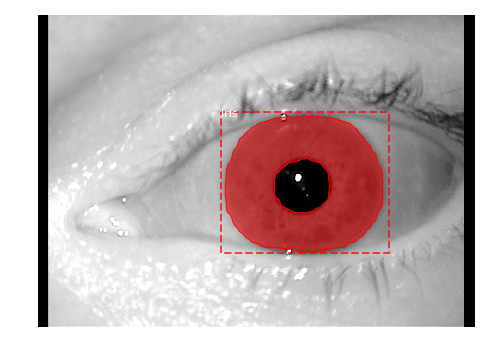

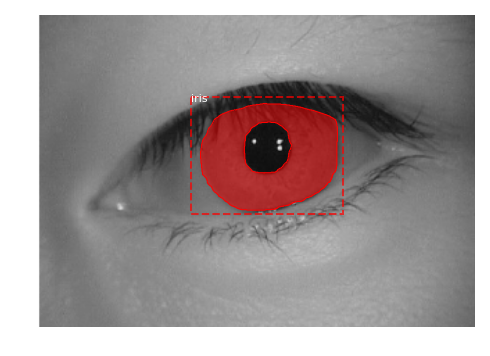

In [8]:
import matplotlib.pyplot as plt
import os
import glob
import cv2
from sklearn import model_selection
import re
from scipy import ndimage
import skimage.io
from PIL import Image
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb
import time
from Model.visualize import display_images,display_weight_stats
import Model.utils as utils

class_names = ['BG','iris']

# Root directory of the project

# Load images from folder

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

#Inference one at a time, change to batch (Memory per image calculate)
def runonFolder(inputFolder,saveFolder,maskFolder,centered):
    os.chdir(folderPath)
    imList = sorted(glob.glob("*"),key=numericalSort)
    print (  len(imList))
    avgTime = 0.0
    
    irisFolder = saveFolder
    if not os.path.exists(irisFolder):
        os.makedirs(irisFolder)
        
    maskFolder = maskFolder
    if not os.path.exists(maskFolder):
        os.makedirs(maskFolder)
    os.chdir(irisFolder)

    
    newpath = saveFolder
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    start = time.time()

    print ("Saving in " + os.getcwd())
    for i in range(len(imList)):
        im = imread(folderPath + "/" + imList[i])
        image = skimage.color.gray2rgb(im)
        im, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=inference_config.IMAGE_MIN_DIM,
        min_scale=inference_config.IMAGE_MIN_SCALE,
        max_dim=inference_config.IMAGE_MAX_DIM,
        mode="pad64")

        results = model.detect([im], verbose=0)
        r = results[0]
        mask = r['masks'][:, :, 0]
        end = time.time()
        avgTime += (end-start)

        print (end-start)

        saveName = imList[i]

        mask = r['masks'][:, :, 0]
        bbox = r['rois'][0]
#             print (bbox)
        saveName = re.sub('[.].*','.png',saveName)

        if(centered):
            cx = ((bbox[0]+bbox[2])//2)
            cy = ((bbox[1]+bbox[3])//2)
            PADDING = 20

            croppedMask = mask[bbox[0]-PADDING:bbox[2]+PADDING, bbox[1]-PADDING:bbox[3]+PADDING]
            croppedIm = im[bbox[0]-PADDING:bbox[2]+PADDING, bbox[1]-PADDING:bbox[3]+PADDING]


            tIm = croppedIm[:,:,0]
            croppedMask = croppedMask*255

            anded =np.bitwise_and(tIm,croppedMask)
            matplotlib.image.imsave(saveName, anded) 
        if(not centered):
            tIm = im[:,:,0]
            mask = mask*255
            anded =np.bitwise_and(tIm,mask)
            matplotlib.image.imsave(saveName, anded) 

#         mResized = resize(anded, (200, 200))

        saveName = re.sub('[.].*','.png',saveName)
        visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'],class_names,show_bbox = True, ax=get_ax())
        matplotlib.image.imsave(maskFolder + "/" + saveName, mask) 


    print (avgTime)

#Folder containing iris images
folderPath = ROOT_DIR+"/b"

#Segmented masks stored in /segmented
runonFolder(folderPath,ROOT_DIR+"/segmented",ROOT_DIR+"/masks",centered = 1)

